# Explainable Artificial Intelligence (xAI)

## Background
- Success stories of AI in diverse applications(i.e. Autonomous Driving, Manufacturing, Game, Medical..)
- Limitations : Inability to *explain* the model's thoughts
   - AI model is usually considered as *opaque* or *black-box* model
- Importance of Explainability
   1. Validation : Simultaneously validate how the machine thinks is to how the Human thinks is
   2. Trustness : Can we rely on it without knowing why it did so?
   3. Legal Compliances : Movement to record the reason why and how the AI machines make such decisions. 

## What we are trying to do?
- Trade-off between *Performance* and *Explainability*
- Presents a novel method to generate explanations for AI machines

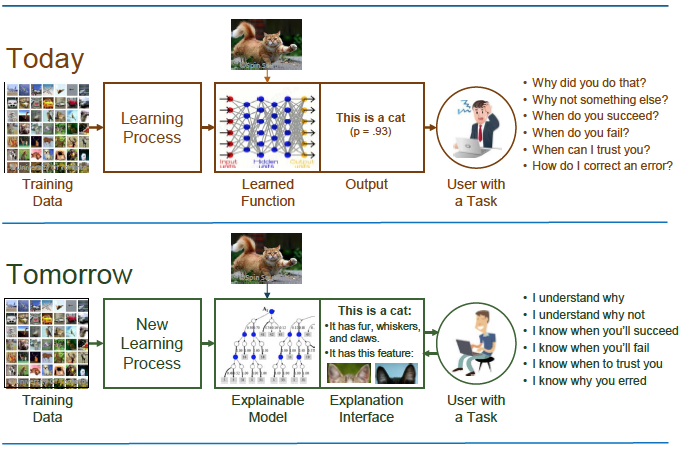
<center>< Comparision results of Traditional AI model(Top) and Explainable AI mode(Bottom) ></center>
    <center>Source : *Gunning 2016, Explainable Artificial Intelligence, DARPA* </center>

## Demo : Highlighting spatio attention of an image by LIME (Local Interpretable Model-agnostic Explanation)

In [1]:
import os
import keras
from keras.applications import inception_resnet_v2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.inception_resnet_v2 import decode_predictions

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from skimage.io import imread

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Notebook run using keras: 2.2.4


### Using InceptionResNetV2 Model as a object detection model

In [2]:
# create the base pre-trained model
base_model = InceptionResNetV2(weights='imagenet', include_top=True)
#base_model = VGG19(weights='imagenet', include_top=True)

225214464/225209952 [==============================] - 46s 0us/step


In [3]:
def transform_img_fn(path_list):
    output = []
    for img_path in path_list:
        img = load_img(img_path, target_size=(299,299)) # For Inception_resnet_v2
        #img = load_img(img_path, target_size=(224,224)) # For VGG19
        
        x = img_to_array(img)  # this is a Numpy array with shape (3(RGB), width, height)
        x = np.expand_dims(x, axis=0) # this is a Numpy array with shape (1, 3(RGB), width, height)
        x = preprocess_input(x)
        output.append(x)
    return np.vstack(output)


### Loading images

Number of Images found :  8


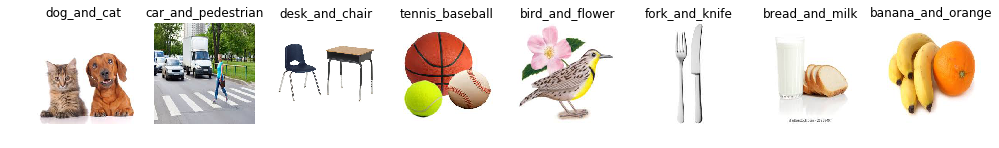

In [4]:
import glob

file_list = glob.glob("./Images/*/*", recursive=True)
print('Number of Images found : ', len(file_list))
#print(file_list)

img_list = transform_img_fn(file_list)

fig = plt.figure()
fig.set_size_inches(17,10)

for idx, img in enumerate(img_list):
    ax = plt.subplot(1,8,idx+1)
    ax.set_title(file_list[idx].split('/')[2])
    plt.axis('off')
    plt.imshow(img_list[idx] / 2 + 0.5)
    #plt.imshow((img_list[idx]/2 + 0.5).astype(np.uint8))


### Do classification what the object is!

In [5]:
#preds = base_model.predict(np.expand_dims(img_list[0], axis=0))
preds = base_model.predict(img_list, verbose=1)

#print(decode_predictions(preds))

for idx, x in enumerate(decode_predictions(preds, top=10)):
    target = file_list[idx].split('/')[2]
    #pred   = [j[1]+'('+str(j[2].round(2))+')' for j in x]
    for j in x:
        print(target+'\t'+j[1]+'('+str(j[2].round(3))+')')
    print('-'*100)

40960/35363 [==================================] - 0s 2us/step
dog_and_cat	redbone(0.625)
dog_and_cat	Rhodesian_ridgeback(0.073)
dog_and_cat	vizsla(0.018)
dog_and_cat	bloodhound(0.009)
dog_and_cat	tabby(0.006)
dog_and_cat	English_foxhound(0.003)
dog_and_cat	black-and-tan_coonhound(0.002)
dog_and_cat	Egyptian_cat(0.002)
dog_and_cat	tiger_cat(0.002)
dog_and_cat	Sussex_spaniel(0.002)
----------------------------------------------------------------------------------------------------
car_and_pedestrian	moving_van(0.806)
car_and_pedestrian	trailer_truck(0.009)
car_and_pedestrian	recreational_vehicle(0.004)
car_and_pedestrian	ambulance(0.003)
car_and_pedestrian	garbage_truck(0.003)
car_and_pedestrian	minibus(0.003)
car_and_pedestrian	water_tower(0.003)
car_and_pedestrian	police_van(0.002)
car_and_pedestrian	jinrikisha(0.002)
car_and_pedestrian	mobile_home(0.001)
----------------------------------------------------------------------------------------------------
desk_and_chair	folding_chair(0

### Highlighting regions what makes the model cliassify sth to sth

In [7]:
import os, sys
try:
    import lime
except:
    !pip install --upgrade pip
    !pip install lime

import lime
from lime import lime_image


In [8]:
explainer = lime_image.LimeImageExplainer()

In [9]:
%%time

explanation = explainer.explain_instance(
    img_list[0], 
    base_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=30000)

CPU times: user 5min 10s, sys: 44.8 s, total: 5min 55s
Wall time: 5min 26s


In [17]:
%%time

explanation_5 = explainer.explain_instance(
    img_list[5], 
    base_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=30000)

CPU times: user 5min 32s, sys: 50.9 s, total: 6min 23s
Wall time: 5min 45s


In [10]:
%%time

explanation_3 = explainer.explain_instance(
    img_list[3], 
    base_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=30000)

explanation_7 = explainer.explain_instance(
    img_list[7], 
    base_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=30000)

CPU times: user 9min 42s, sys: 1min 26s, total: 11min 9s
Wall time: 10min 10s


### Check the result

[168, 159, 211, 163, 281]


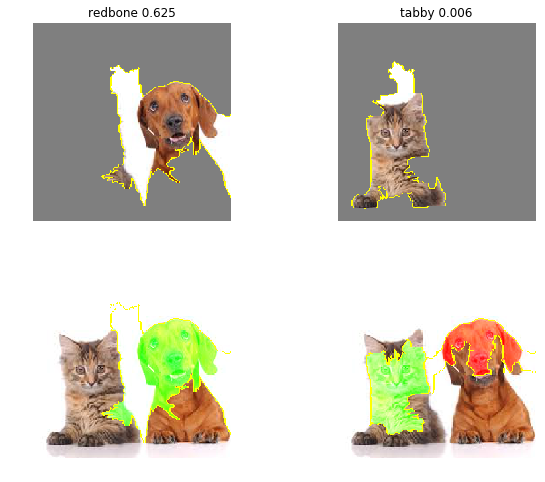

In [19]:
from skimage.segmentation import mark_boundaries

print(explanation.top_labels)

T1_IDX = 0
T2_IDX = 4


temp_2, mask_2 = explanation.get_image_and_mask(
    explanation.top_labels[T2_IDX], 
    positive_only=True, 
    num_features=10, 
    hide_rest=True)


fig = plt.figure()
fig.set_size_inches(10,8)

# Figure 1
## UPPER PART
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[T1_IDX], 
    positive_only=True, 
    num_features=10, 
    hide_rest=True)

ax = plt.subplot(2,2,1)
TTL1 = decode_predictions(preds)[0][T1_IDX][1] + ' ' + str(decode_predictions(preds)[0][T1_IDX][2].round(3))
ax.set_title(TTL1)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## LOWER PART

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[T1_IDX], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)

ax = plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# ---------------------------------------------------------------------------------

# Figure 2
## UPPER PART
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[T2_IDX], 
    positive_only=True, 
    num_features=10, 
    hide_rest=True)

ax = plt.subplot(2,2,2)

TTL2 = decode_predictions(preds)[0][T2_IDX][1] + ' ' + str(decode_predictions(preds)[0][T2_IDX][2].round(3))
ax.set_title(TTL2)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## LOWER PART

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[T2_IDX], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)

ax = plt.subplot(2,2,4)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

[954, 950, 951, 940, 953]


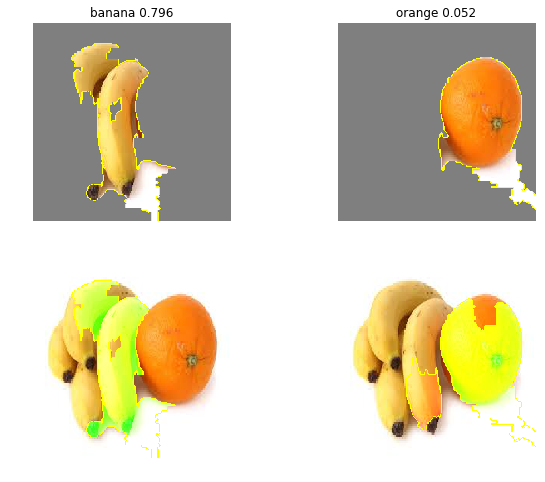

In [15]:
from skimage.segmentation import mark_boundaries

print(explanation_7.top_labels)

T1_IDX = 0
T2_IDX = 1

fig = plt.figure()
fig.set_size_inches(10,8)

# Figure 1
## UPPER PART
temp, mask = explanation_7.get_image_and_mask(
    explanation_7.top_labels[T1_IDX], 
    positive_only=True, 
    num_features=10, 
    hide_rest=True)

ax = plt.subplot(2,2,1)
TTL1 = decode_predictions(preds)[7][T1_IDX][1] + ' ' + str(decode_predictions(preds)[7][T1_IDX][2].round(3))
ax.set_title(TTL1)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## LOWER PART

temp, mask = explanation_7.get_image_and_mask(
    explanation_7.top_labels[T1_IDX], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)

ax = plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# ---------------------------------------------------------------------------------

# Figure 2
## UPPER PART
temp, mask = explanation_7.get_image_and_mask(
    explanation_7.top_labels[T2_IDX], 
    positive_only=True, 
    num_features=10, 
    hide_rest=True)

ax = plt.subplot(2,2,2)

TTL2 = decode_predictions(preds)[7][T2_IDX][1] + ' ' + str(decode_predictions(preds)[7][T2_IDX][2].round(3))
ax.set_title(TTL2)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## LOWER PART

temp, mask = explanation_7.get_image_and_mask(
    explanation_7.top_labels[T2_IDX], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)

ax = plt.subplot(2,2,4)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

[813, 473, 618, 499, 477]


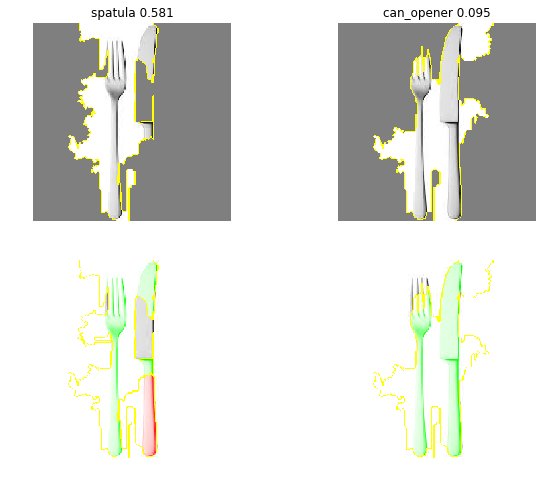

In [18]:
from skimage.segmentation import mark_boundaries

print(explanation_5.top_labels)

T1_IDX = 0
T2_IDX = 1

fig = plt.figure()
fig.set_size_inches(10,8)

# Figure 1
## UPPER PART
temp, mask = explanation_5.get_image_and_mask(
    explanation_5.top_labels[T1_IDX], 
    positive_only=True, 
    num_features=10, 
    hide_rest=True)

ax = plt.subplot(2,2,1)
TTL1 = decode_predictions(preds)[5][T1_IDX][1] + ' ' + str(decode_predictions(preds)[5][T1_IDX][2].round(3))
ax.set_title(TTL1)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## LOWER PART

temp, mask = explanation_5.get_image_and_mask(
    explanation_5.top_labels[T1_IDX], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)

ax = plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# ---------------------------------------------------------------------------------

# Figure 2
## UPPER PART
temp, mask = explanation_5.get_image_and_mask(
    explanation_5.top_labels[T2_IDX], 
    positive_only=True, 
    num_features=10, 
    hide_rest=True)

ax = plt.subplot(2,2,2)

TTL2 = decode_predictions(preds)[5][T2_IDX][1] + ' ' + str(decode_predictions(preds)[5][T2_IDX][2].round(3))
ax.set_title(TTL2)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## LOWER PART

temp, mask = explanation_5.get_image_and_mask(
    explanation_5.top_labels[T2_IDX], 
    positive_only=False, 
    num_features=10, 
    hide_rest=False)

ax = plt.subplot(2,2,4)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## Future works
### Textual or Graphic Explanations for Autonomous Driving
- Propose explainable models that generates rationale for AD / ADAS

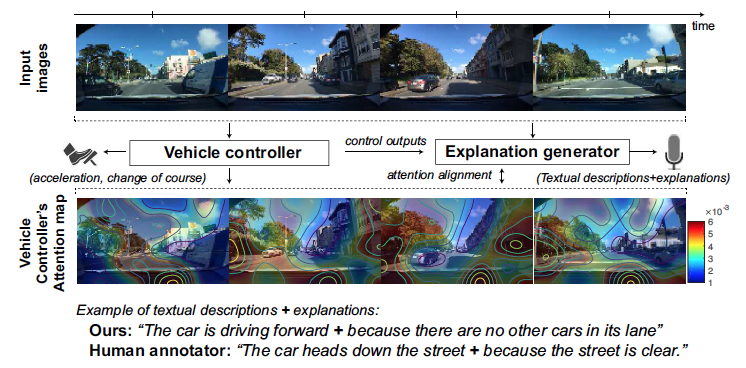
<center>Source : Kim, J., et al. (2018). Textual explanations for self-driving vehicles. 15th European Conference on Computer Vision, Springer.</center>